In [63]:
 %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import mahotas as mh
from pylab import imshow, gray, show
from PIL import Image
import PIL.ImageOps
import imutils

In [96]:
#CODE FROM: https://stackoverflow.com/questions/9506841/using-python-pil-to-turn-a-rgb-image-into-a-pure-black-and-white-image
#This is code to binarize the image--basically reduce the image to a simple image of just 0 values and 255 values
#This is a type of thresholding

from PIL import Image

def binarize_image(img_path, target_path, threshold=200):
    """Binarize an image."""
    image_file = Image.open(img_path)
    image = image_file.convert('L')  # convert image to monochrome
    image = np.array(image)
    image = binarize_array(image, threshold)
    return image
    #imsave(target_path, image)


def binarize_array(numpy_array, threshold=200):
    """Binarize a numpy array."""
    for i in range(len(numpy_array)):
        for j in range(len(numpy_array[0])):
            if numpy_array[i][j] > threshold:
                numpy_array[i][j] = 255
            else:
                numpy_array[i][j] = 0
    return numpy_array

In [137]:
#We load and binarize each image of the pieces to use later on
pawn = binarize_image('new_pawn.jpg', None)
pawn = cv2.resize(pawn, (700, 700))
pawn = cv2.bitwise_not(pawn)
queen = binarize_image('new_queen.jpg', None)
queen = cv2.resize(queen, (700, 700))
rook = binarize_image('new_rook.jpg', None)
rook = cv2.resize(rook, (700, 700))
bishop = binarize_image('new_bishop.jpg', None)
bishop = cv2.resize(bishop, (700, 700))
board = plt.imread('new_board.jpg')
possible_pieces = [['pawn',pawn],['rook',rook], ['queen',queen], ['bishop',bishop]]

In [132]:
#We define a method to find the letter according to a picture by comparing the squared difference between each picture
#and the current picture, the picture with the least difference is your picture!
def find_closest_letter(input_image):
    input_image = list(input_image.getdata())
    least_squared_sum = np.inf
    piece = None
    for chess in possible_pieces:
        piece_name = chess[0]
        chess_piece = chess[1].copy()
        #chess_piece = cv2.resize(input_image, (input_image.size[0], input_image.size[1]))
        squared_difference =  np.sum(np.square(input_image-chess_piece.flatten()))
        print("piece_name:{}\t squared_difference:{}".format(piece_name, squared_difference))
        if(squared_difference < least_squared_sum):
            least_squared_sum = squared_difference
            piece = piece_name
    return piece

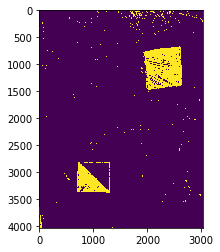

In [51]:
#We take the board image and set it up for analysis by thresholding
#This makes the dot/nucleus detection much easier
im = cv2.imread('new_board.jpg')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,90,255,0)
photo = cv2.bitwise_not(thresh)
plt.imshow(photo)

Found 8078 nuclei.


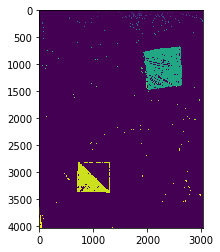

In [52]:
#We find the "nucleus" in the image using a library called mahotas
labeled, n_nucleus  = mh.label(photo)
print('Found {} nuclei.'.format(n_nucleus))
imshow(labeled)
show()

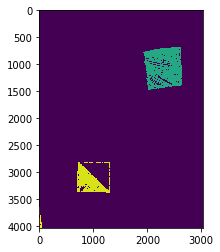

In [54]:
#We filter out the "nucleuses" that are less than a specific size to get the ones associated with the pieces
sizes = mh.labeled.labeled_size(labeled)
too_small = np.where(sizes < 10000)
labeled = mh.labeled.remove_regions(labeled, too_small)
imshow(labeled)
show()

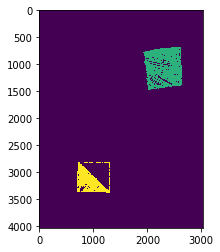

In [55]:
#We remove the nucleuses on the border to just have the two pieces in our picture
labeled = mh.labeled.remove_bordering(labeled)
imshow(labeled)
show()

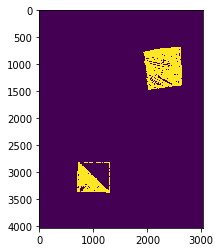

True

In [61]:
#Make it all the same color for ease of analysis and save it in a "filtered image"
labeled[labeled > 0] = 255
imshow(labeled)
show()
cv2.imwrite("filtered.png", labeled)

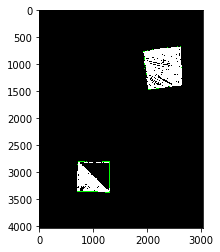

In [124]:
#Write code to identify the shapes in the image
#Since at this point we literally just have the images of the shapes isolated it should be easier
countours = []
def find_shapes(image):
    im = cv2.imread(image)
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(imgray, (5, 5), 0)
    ret,thresh = cv2.threshold(blurred,100,255,0)
    resized = imutils.resize(thresh, width=300)
    ratio = im.shape[0] / float(resized.shape[0])
    
    im2, contours, hierarchy = cv2.findContours(resized.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cv2.findContours(resized.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    for c in cnts:
        c = c.astype("float")
        c *= ratio
        c = c.astype("int")
        countours.append(c)
        cv2.drawContours(im, [c], -1, (0, 255, 0), 2)
    plt.imshow(im)
    return im 

answer = find_shapes('filtered.png') 

In [138]:
#Then we crop out the pieces of interested via the contour coordinates
#And then use our earlier method to identify the pieces
def get_crop_coordinates(contour):
    arr = [i[0] for i in contour]
    maximum = max(arr,key=lambda item:item[0]+item[1])
    minimum = min(arr,key=lambda item:item[0]+item[1])
    return (minimum[0],minimum[1],maximum[0],maximum[1])

pieces_identified = []
for countour in countours:
    coordinates = get_crop_coordinates(countour)
    im = Image.open("filtered.png")
    img2 = im.crop(coordinates)
    img2 = img2.resize((700,700))
    #imshow(img2)
    #show()
    pieces_identified.append(find_closest_letter(img2))

print("We identified the following pieces on the board: {}".format(pieces_identified))

piece_name:pawn	 squared_difference:15840774907
piece_name:rook	 squared_difference:19181480638
piece_name:queen	 squared_difference:6191806465
piece_name:bishop	 squared_difference:27290136893
piece_name:pawn	 squared_difference:5800692547
piece_name:rook	 squared_difference:17930066608
piece_name:queen	 squared_difference:19339344325
piece_name:bishop	 squared_difference:15026459123
We identified the following pieces on the board: ['queen', 'pawn']


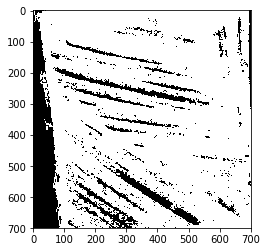

piece_name:pawn	 squared_difference:5800692547
piece_name:rook	 squared_difference:17930066608
piece_name:queen	 squared_difference:19339344325
piece_name:bishop	 squared_difference:15026459123


'pawn'

In [139]:
imshow(img2)
show()
find_closest_letter(img2)

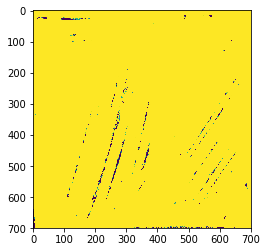

In [136]:
plt.imshow()